# Logistic Regression

## School admittance example data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Issue with `import matplotlib.pyplot as plt` on OSX? See this [stack overflow](https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python) answer.
```
import matplotlib as mpl 
mpl.use('TkAgg')
import matplotlib.pyplot as plt
```

In [2]:
import os
path = os.getcwd() + '/data/ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
# Panda's data frames of positive and negative examples
positive = data[data['Admitted'].isin([1])]  
negative = data[data['Admitted'].isin([0])]

Text(0, 0.5, 'Exam 2 Score')

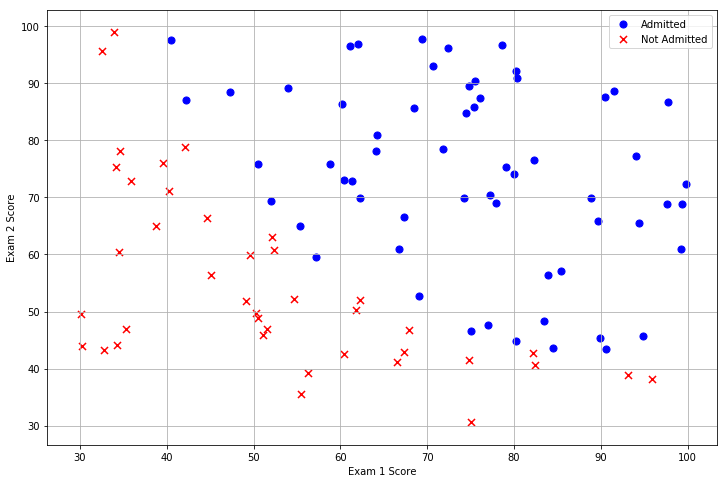

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))  
ax.grid(True)
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')  
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')  
ax.legend()  
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')  

## Set up the data

In [5]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:, 0:cols-1]
y = data.iloc[:, cols-1:cols]

# convert to numpy arrays and initialize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

In [6]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

### Hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [7]:
from scipy.special import expit  # Vectorized sigmoid function

def h(theta, X):
    return expit(np.dot(X, theta))

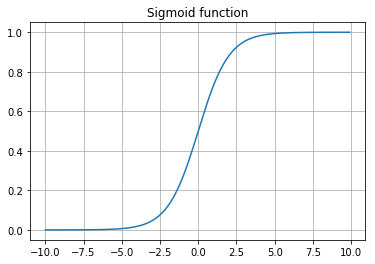

In [8]:
myx = np.arange(-10,10,.1)
plt.plot(myx,expit(myx))
plt.title("Sigmoid function")
plt.grid(True)

### Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### ...vectorized
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### ...vectorized
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [9]:
def cost(theta, X, y, learning_rate=0.): 
    """Calculate the total cost for every example with a set of parameter values.
    
    Set learning_rate to non-zero to include regularization.

    :param numpy.ndarray theta: An n- dimensional vector of initial parameter values
    :param numpy.ndarray X: An array of examples with n columns and m rows
    :param numpy.ndarray y: The labeled prediction, m rows and 1 column
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :rtype: float
    """
    m = len(y)
    term1 = np.dot(-np.array(y).T, np.log(h(theta, X)))
    term2 = np.dot((1-np.array(y)).T, np.log(1-h(theta, X)))
    regterm = (learning_rate/2) * np.sum(np.dot(theta[1:].T, theta[1:])) #Skip theta0
    return float( (1./m) * ( np.sum(term1 - term2) + regterm ) )

In [10]:
# cost with theta initialized to 0
cost(theta, X, y, 0)

0.6931471805599453

### Gradient (partial derivative)

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
#### ...vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$


#### Regularized Gradient

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### ...vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [32]:
def gradient(theta, X, y, learning_rate):
    """Calculate a single gradient step.
    
    Only compute a single gradient step so this function can be used with an optimization function.
    
    :param numpy.ndarray theta: An array of parameter values to use
    :param numpy.ndarray X: An array of examples
    :param numpy.ndarray y: The labeled prediction for each example
    :param int learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :return: An ndarray[int] of gradient values
    :rtype: numpy.ndarray
    """
    # convert to np matrices for convenience of np's matrix operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = len(X)

    # find number of parameters and initialize a gradient value for each
    parameters = int(theta.ravel().shape[1])  # shape[1] only exists for matrix, not array
    grad = np.zeros(parameters)
    
    # calculate the error term to use in the gradient function
    # h(x) - y
    error = h(theta.T, X) - y  # error is an ndarray for each matrix operation
    
    # calculate the gradient value for each parameter using the error value
    # (1/m) * sum(error*x)
    for i in range(parameters):
        term = np.multiply(error, X[:, i])
        
        # skip regularization for theta_0
        if i == 0:
            grad[i] = (1/m) * np.sum(term)  # sum the values for every matrix operation
        else:
            grad[i] = (1/m) * np.sum(term) + ((learning_rate / m) * theta[:, i])
        
    return grad

## Optimize the parameters
scipy has similar optimization functions to Matlab's `fminunc`. `fmin_tnc` wraps a C implementation of the truncated Newton algorithm, and returns the optimized parameters, number of iterations used, and an return code.

In [33]:
from scipy import optimize

result = optimize.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y, 0))
print("Optimal theta values:", result[0], "-", type(result[0]))
print("in", result[1], "iterations.")

Optimal theta values: [-25.16130086   0.20623139   0.20147139] - <class 'numpy.ndarray'>
in 3 iterations.


In [35]:
# result[0] is an np.ndarray with the optimal theta values
print("Optimal cost", cost(result[0], X, y, 0))

Optimal cost 0.2034977015897144


### Alternative without derivative terms

scipy's `fmin` only needs the cost function.

In [36]:
def optimizeTheta(theta, X, y, learning_rate=0.):
    result = optimize.fmin(cost, x0=theta, args=(X, y, learning_rate), maxiter=400, full_output=True)
    return result[0], result[1]

In [37]:
theta, mincost = optimizeTheta(theta, X, y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 66
         Function evaluations: 113


In [38]:
print("Optimal theta values:", theta, "-", type(theta))

Optimal theta values: [-25.16130062   0.20623142   0.20147143] - <class 'numpy.ndarray'>


## Plot the decision boundary

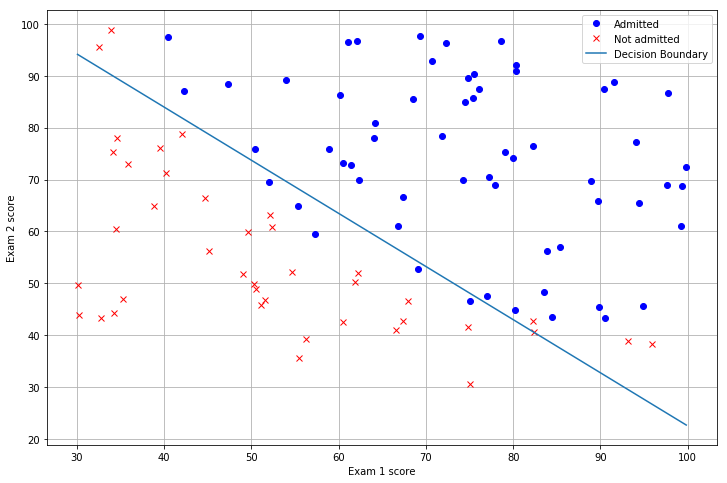

In [39]:
# now try using np array's to plot data
pos = np.array([array for i, array in enumerate(X) if y[i] == 1])
neg = np.array([array for i, array in enumerate(X) if y[i] == 0])

plt.figure(figsize=(12, 8))
plt.plot(pos[:, 1], pos[:, 2], 'bo', label='Admitted')
plt.plot(neg[:, 1], neg[:, 2], 'rx', label='Not admitted')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.grid(True)

# pick two points on decision boundary, draw a line
# h = 0 OR theta0 + theta1*x1 + theta2*x2 = 0
# y = mx + b is replaced by x2 = (-1/thetheta2)(theta0 + theta1*x1)
boundary_xs = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
boundary_ys = (-1./theta[2]) * (theta[0] + theta[1]*boundary_xs)
plt.plot(boundary_xs, boundary_ys, '-', label='Decision Boundary')

plt.legend()

In [40]:
# For a student with scores of 45 and 85...
print(h(theta, np.array([1, 45., 85.])))

0.7762915904112411


## Make some predictions

In [28]:
def predict(theta, X):
    """Applies the logistic regression hypothesis to a data set and given parameters.
    
    :param numpy.ndarray theta: Matrix of theta values
    :param numpy.ndarray X: Array of examples to predict
    
    :returns: A list of 1s or 0s for each entry in X
    :rtype: list[int]
    """
    probability = h(theta, X)
    return [1 if x >= 0.5 else 0 for x in probability]

Make a prediction on the training set (X). This value is probably high though, because some data should be held out for a cross validation set.

In [41]:
predictions = predict(theta, X)  # X is still an ndarray
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0))
           else 0
           for (a, b) in zip(predictions, y)]

# sum(map(int, correct)) is total number of 1s in correct, a vector of 1s and 0s
# modulus this with the length of the vector for the accuracy
accuracy = (sum(map(int, correct)) % len(correct))
print('accuracy: ', accuracy)

accuracy:  89


# Regularization

## Factory test result example data set

In [101]:
path = os.getcwd() + '/data/ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Text(0, 0.5, 'Test 2 Score')

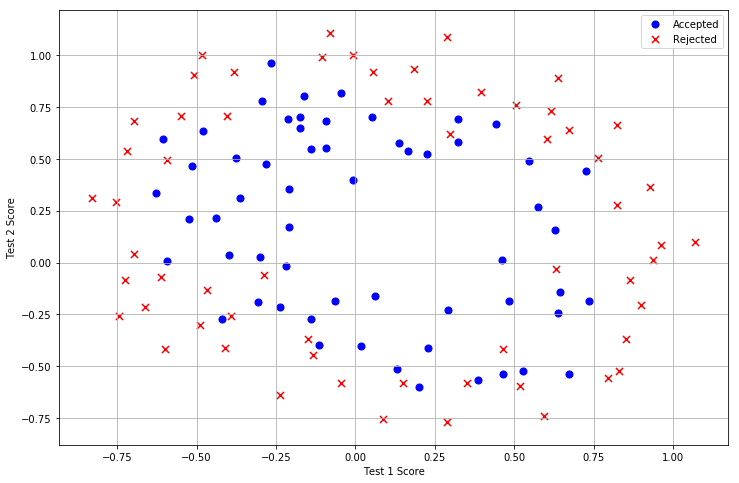

In [102]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

In [103]:
degree = 5
x1 = data2['Test 1']
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

for i in range(1, degree):
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


### Construct features new features
Derive them from polynomials of the original features when there is no linear decision boundary.

## Test the new cost and gradient functions with learning rate added

In [104]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(11)

learningRate = 1.

computeCost(theta2, X2, y2, learningRate)  

0.6931471805599454

In [105]:
print(type(theta2), type(X2), type(y2))
print(theta2.shape, X2.shape, y2.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(11,) (118, 11) (118, 1)


### Find new optimal parameters

In [107]:
gradient(theta2, X2, y2, learningRate)

array([0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
       0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
       0.00309594])

todo - I think there is a bug using fmin_tnc here.. these parameters are wrong and do not lead to a better accuracy. Moving on for now

In [108]:
result2 = opt.fmin_tnc(func=computeCost, x0=theta2, fprime=gradient, args=(X2, y2, learningRate))
result2

(array([ 0.53010247,  0.29075567, -1.60725764, -0.58213819,  0.01781027,
        -0.21329508, -0.40024142, -1.3714414 ,  0.02264304, -0.9503358 ,
         0.0344085 ]), 22, 1)

## Make some predictions, now with regularization

In [109]:
theta_min = np.matrix(result2[0])

predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0))
           else 0 
           for (a, b) in zip(predictions, y2)]

accuracy = (sum(map(int, correct)) % len(correct))
print("accuracy", accuracy)

accuracy 78


In [110]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())

/Users/joeselvik/.virtualenvs/machine-learning-coursera/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [111]:
model.score(X2, y2)

0.6610169491525424

# Regularization

## Load and plot the data

In [44]:
datafile = 'data/ex2data2.txt'
cols = np.loadtxt(datafile, delimiter=',', usecols=(0,1,2), unpack=True) 

X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X,0,1,axis=1)

pos = np.array([arr for i, arr in enumerate(X) if y[i] == 1])
neg = np.array([arr for i, arr in enumerate(X) if y[i] == 0])

In [45]:
def plotData():
    plt.plot(pos[:,1],pos[:,2],'bo',label='y=1')
    plt.plot(neg[:,1],neg[:,2],'rx',label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

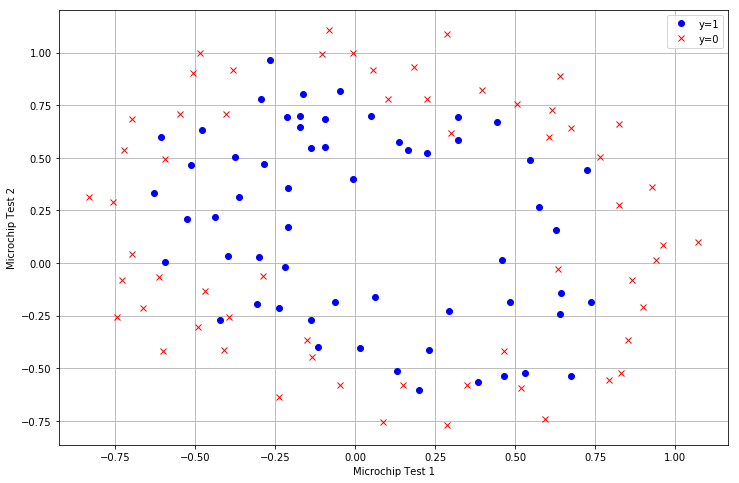

In [47]:
plt.figure(figsize=(12, 8))
plotData()


## Feature Mapping

In [57]:
def map_feature(x1col, x2col, degrees=6):
    """Builds a n x 28 matrix of features from two given columns of inputs."""
    out = np.ones( (x1col.shape[0], 1) )
    
    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i+1)
            term2 = x2col ** (j)
            term = (term1 * term2).reshape(term1.shape[0], 1)
            out = np.hstack((out, term))
    return out

In [70]:
# feature mapped X matrix
mapped_X = map_feature(X[:, 1], X[:, 2])
mapped_X[1]

array([ 1.00000000e+00,  8.60107856e-03,  5.89122275e-03, -7.97681228e-04,
       -5.46363780e-04, -3.74226408e-04,  7.39785525e-05,  5.06708697e-05,
        3.47065055e-05,  2.37718739e-05, -6.86091891e-06, -4.69931780e-06,
       -3.21875073e-06, -2.20465113e-06, -1.51005374e-06,  6.36295342e-07,
        4.35824131e-07,  2.98513381e-07,  2.04463755e-07,  1.40045404e-07,
        9.59226992e-08, -5.90113026e-08, -4.04192016e-08, -2.76847279e-08,
       -1.89623776e-08, -1.29880909e-08, -8.89606297e-09, -6.09326937e-09])

## Cost and Gradient

In [73]:
initial_theta = np.zeros((mappedX.shape[1], 1))
cost(initial_theta, mapped_X, y, 0.)

0.6931471805599454

### Optimize theta and cost
This time using `optimize.minimize` instead of `optimize.fmin`.

In [75]:
def optimizeRegularizedTheta(theta, X, y, learning_rate=0.):
    result = optimize.minimize(cost, theta, args=(X, y, learning_rate),  method='BFGS', options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun
    
theta, mincost = optimizeRegularizedTheta(initial_theta,mappedX,y)
print("Optimized theta values:", theta)
print("Optimized cost", mincost)

Optimized theta values: [[ 4.75847865e-01  3.87521247e+00  2.69865798e+01 -2.74834294e+01
   1.69216375e+01 -5.60060197e+00  5.03344399e+01  2.16199309e+02
  -1.63602370e+02 -7.13503012e+02  1.52386610e+02 -4.35290592e+02
   1.08785864e+03  7.17628047e+02 -1.97105679e+03 -1.66418303e+02
  -4.86811959e+02  9.81861096e+02  1.01000719e+03 -1.48855713e+03
  -3.48113139e+02 -1.99186423e+02  5.05790381e+02 -8.38990462e+02
  -5.84937835e+00 -1.17715084e+03  1.05669808e+02 -4.05039246e+02]]
Optimized cost 0.38493332668414076
